In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [5]:
import matplotlib
matplotlib.use('Agg')
import dlib
import cv2
import os
import re
import json
from pylab import *
from PIL import Image, ImageChops, ImageEnhance
from IPython.display import Image,display
from PIL import Image
import requests
from io import BytesIO

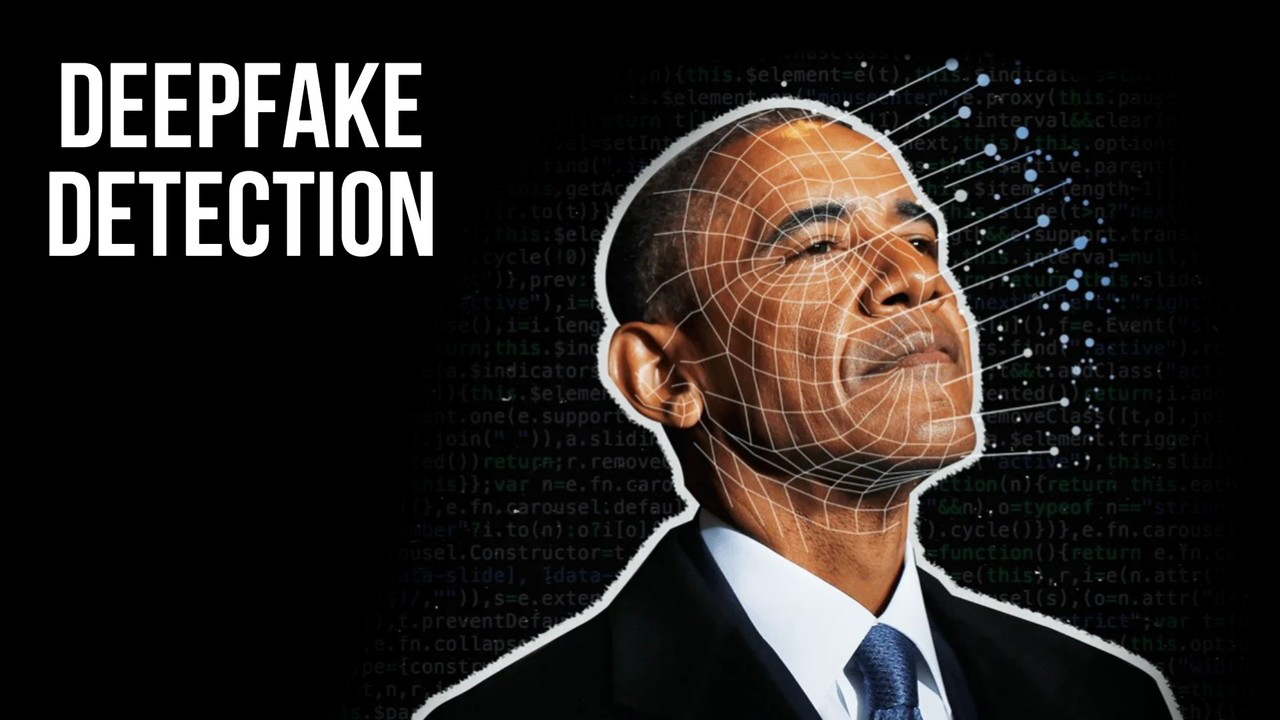

In [7]:
url = 'https://raw.githubusercontent.com/GURU-DUTT/Deepfake-Detection/main/intro_1280x720.jpg'
page = requests.get(url)
Image.open(BytesIO(page.content))

In [ ]:
cd "/gdrive/MyDrive/Colab Notebooks/Deepfake Modelling/deepfake-detection"

/gdrive/MyDrive/Colab Notebooks/Deepfake Modelling/deepfake-detection


In [ ]:
ls

deepfake-model.h5  fake/  real/  test_videos/  train_sample_videos/


In [ ]:
train_frame_folder = 'train_sample_videos'
train_frame_folder

'train_sample_videos'

In [ ]:
check_dir = '/gdrive/MyDrive/Colab Notebooks/Deepfake Modelling/deepfake-detection/real'
check_dir

'/gdrive/MyDrive/Colab Notebooks/Deepfake Modelling/deepfake-detection/real'

In [ ]:
train_frame_folder = 'train_sample_videos'
with open(os.path.join(train_frame_folder, 'metadata.json'), 'r') as file:
    data = json.load(file)
list_of_train_data = [f for f in os.listdir(train_frame_folder) if f.endswith('.mp4')]
detector = dlib.get_frontal_face_detector()
for vid in list_of_train_data:
    count = 0
    cap = cv2.VideoCapture(os.path.join(train_frame_folder, vid))
    frameRate = cap.get(5)
    while cap.isOpened():
        frameId = cap.get(1)
        ret, frame = cap.read()
        if ret != True:
            break
        if frameId % ((int(frameRate)+1)*1) == 0:
            face_rects, scores, idx = detector.run(frame, 0)
            for i, d in enumerate(face_rects):
                x1 = d.left()
                y1 = d.top()
                x2 = d.right()
                y2 = d.bottom()
                crop_img = frame[y1:y2, x1:x2]
                if data[vid]['label'] == 'REAL':
                    cv2.imwrite('/gdrive/MyDrive/Colab Notebooks/Deepfake Modelling/deepfake-detection/real/'+vid.split('.')[0]+'_'+str(count)+'.png', cv2.resize(crop_img, (128, 128)))
                elif data[vid]['label'] == 'FAKE':
                    cv2.imwrite('/gdrive/MyDrive/Colab Notebooks/Deepfake Modelling/deepfake-detection/fake/'+vid.split('.')[0]+'_'+str(count)+'.png', cv2.resize(crop_img, (128, 128)))
                count+=1

In [ ]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
input_shape = (128, 128, 3)
data_dir = '/gdrive/MyDrive/Colab Notebooks/Deepfake Modelling/deepfake-detection'


real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.png')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.png')]

X = []
Y = []

for img in real_data:
    X.append(img_to_array(load_img(data_dir+'/real/'+img)).flatten() / 255.0)
    Y.append(1)
for img in fake_data:
    X.append(img_to_array(load_img(data_dir+'/fake/'+img)).flatten() / 255.0)
    Y.append(0)

Y_val_org = Y

#Normalization for x and y
X = np.array(X)
Y = to_categorical(Y, 2)

#Reshaping it based on 4D size, -1 automatically finds req size
X = X.reshape(-1, 128, 128, 3)

#Train-Test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

Net_model = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
Net_model.trainable = True
model = Sequential()
model.add(Net_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])
model.summary()

219062272/219055592 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 2, 2, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 3074      
Total params: 54,339,810
Trainable params: 54,279,266
Non-trainable params: 60,544
_________________________________________________________________


In [ ]:
EPOCHS = 20
BATCH_SIZE = 100
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val, Y_val), verbose = 1)

Epoch 1/20
30/30 [==============================] - 72s 804ms/step - loss: 0.7987 - accuracy: 0.3071 - val_loss: 0.8422 - val_accuracy: 0.4673
Epoch 2/20
30/30 [==============================] - 17s 572ms/step - loss: 0.6749 - accuracy: 0.5340 - val_loss: 0.7666 - val_accuracy: 0.4499
Epoch 3/20
30/30 [==============================] - 17s 584ms/step - loss: 0.5769 - accuracy: 0.7069 - val_loss: 0.7530 - val_accuracy: 0.4152
Epoch 4/20
30/30 [==============================] - 18s 591ms/step - loss: 0.4812 - accuracy: 0.8258 - val_loss: 0.7635 - val_accuracy: 0.4045
Epoch 5/20
30/30 [==============================] - 17s 584ms/step - loss: 0.3903 - accuracy: 0.8842 - val_loss: 0.7699 - val_accuracy: 0.4152
Epoch 6/20
30/30 [==============================] - 17s 583ms/step - loss: 0.3118 - accuracy: 0.9272 - val_loss: 0.7317 - val_accuracy: 0.5220
Epoch 7/20
30/30 [==============================] - 17s 580ms/step - loss: 0.2523 - accuracy: 0.9433 - val_loss: 0.6625 - val_accuracy: 0.6555

In [ ]:
#Creating multiple subplots using fig, (ax1,ax2)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
#InceptionResNetV2 Transfer Learning with Image Augmentation Performance
t = f.suptitle('InceptionResNetV2', fontsize=14)
f.subplots_adjust(top=0.90, wspace=0.4)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch numbers')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch numbers')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

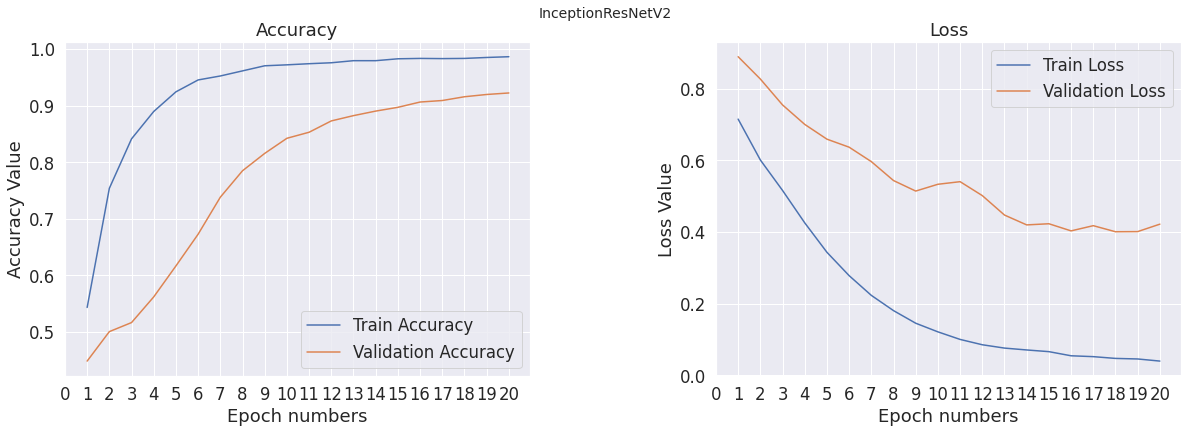

In [ ]:
#printing the confusion matrix respectively
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    #no of obs in i compared to predicted one in j for array vals
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.5) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 20}) # font size
    plt.ylabel('The Actual label', size = 22)
    plt.xlabel('The Predicted label', size = 22)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 17)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 17)
    plt.ylim([2, 0])
    plt.show()
    
print_confusion_matrix(Y_val_org, model.predict_classes(X))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


True positive =  2956
False positive =  30
False negative =  85
True negative =  674




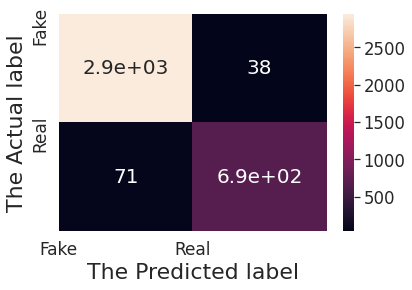

In [ ]:
#Saving the model file
model.save('deepfake-model.h5')

In [ ]:
#checking tensorflow version
tf.__version__

'2.5.0'

In [ ]:
!pip install tk

In [ ]:
#virtual display for tkinter
!apt-get install -y xvfb # Install X Virtual Frame Buffer
import os
os.system('Xvfb :1 -screen 0 1600x1200x16  &')    # create virtual display with size 1600x1200 and 16 bit color. Color can be changed to 24 or 8
os.environ['DISPLAY']=':1.0'

*Final Prediction if a given video is Pristine[1] or a Deepfake[0]*

In [ ]:
"""import tkinter
from tkinter import *
import tkinter.messagebox
from IPython.display import display
"""
input_shape = (128, 128, 3)
pred_data = []
count=0
detector = dlib.get_frontal_face_detector()
cap = cv2.VideoCapture('test_videos/ilqwcbprqa.mp4') #Sample vid
frameRate = cap.get(5) #means CAP_PROP_FPS - Frame rate of the video.
while cap.isOpened():
    frameId = cap.get(1)
    ret, frame = cap.read()
    if ret != True:
        break
    if frameId % ((int(frameRate)+1)*1) == 0:
        face_rects, scores, idx = detector.run(frame, 0)
        for i, d in enumerate(face_rects):
            x1 = d.left()
            y1 = d.top()
            x2 = d.right()
            y2 = d.bottom()
            crop_img = frame[y1:y2, x1:x2]
            data = img_to_array(cv2.resize(crop_img, (128, 128))).flatten() / 255.0
            data = data.reshape(-1, 128, 128, 3)
            #arr a numpy array for return vals from prediction
            arr = model.predict_classes(data)
            print(model.predict_classes(data))
            for x in arr:
              if x == 0:
                count+=1
                
            arrlen = arr.size
if(count>(0.6*arrlen)):
  url = 'https://raw.githubusercontent.com/GURU-DUTT/Deepfake-Detection/main/DF_1_1280x720.jpg'
  page = requests.get(url)
  Image.open(BytesIO(page.content))
else:
  url = 'https://raw.githubusercontent.com/GURU-DUTT/Deepfake-Detection/main/NDF_1280x720.jpg'
  page = requests.get(url)
  Image.open(BytesIO(page.content))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


The given video is a Deepfake Video 

